# **Giới thiệu**

Chúng ta sẽ triển khai **mô hình Hidden Markov Model (HMM)** để thực hiện **Part-of-Speech (POS) tagging** – gán nhãn từ loại cho từng từ trong câu.

POS tagging là một bước quan trọng trong **xử lý ngôn ngữ tự nhiên (NLP)**, giúp các hệ thống hiểu cấu trúc ngữ pháp của văn bản, từ đó hỗ trợ các ứng dụng như phân tích cú pháp, trích xuất thông tin, dịch máy, hay tổng hợp ngôn ngữ.

Trong phần thực nghiệm này, chúng ta sẽ:

1.  **Chuẩn bị dữ liệu**: Sử dụng **Brown Corpus** từ NLTK với tagset chuẩn hóa nhãn **Universal Tagset**.
    
2.  **Train & Evaluate HMM**: Huấn luyện mô hình **POS\_HMM** trên tập train và đánh giá độ chính xác trên tập test, với các tham số khác nhau để phân tích hiệu suất.
    
3.  **Predict POS tagging trên câu ví dụ**: Minh họa khả năng gán nhãn POS cho câu đơn giản và các câu thực tế dài hơn, giúp trực quan hóa kết quả của mô hình.
    

Mục tiêu là xây dựng một pipeline từ **data → train → evaluate → predict**, từ đó đánh giá hiệu quả của HMM trong việc gán nhãn POS và minh họa khả năng áp dụng mô hình trên dữ liệu thực tế.

# 🔴 **CHÚ Ý QUAN TRỌNG TRƯỚC KHI CHẠY NOTEBOOK**

Trong phần **1. Chuẩn bị môi trường**, có cấu hình CONFIG với GAMMA_TUNING:

```python
CONFIG = {
    ...
    "GAMMA_TUNING": False                                              # Cờ kiểm soát huấn luyện và đánh giá
}
```

- Nếu `"GAMMA_TUNING": True` ✅

  - Bạn có thể chạy tất cả các cell trên CPU hoặc GPU.

- Nếu `"GAMMA_TUNING": False` ❌

  - Bạn phải chạy trên môi trường GPU (CUDA) nếu model của bạn train/load trên GPU.

  - Nếu chạy trên CPU, sẽ gặp lỗi khi load model GPU.


# **1. Chuẩn bị môi trường**

Trong bước này, chúng ta sẽ:

-   Clone repository `ml-asm-dna05` chứa file `hmm.py` từ GitHub.
    
-   Thêm đường dẫn module vào `sys.path` để dễ import trong notebook hoặc script.

- Import các thư viện cần thiết (NLTK, sklearn, v.v.).
    

Cấu hình có thể thay đổi:

-   `GIT_REPO`: URL của repository GitHub.
    
-   `CLONE_DIR`: Thư mục lưu repository cục bộ.

-   `GAMMA_TUNING`: Cờ huấn luyện & đánh giá theo gamma để chọn cấu hình tốt nhất.

In [32]:
# ============================================================
# Cấu hình tải repository và branch
# ============================================================
CONFIG = {
    "GIT_REPO": "https://github.com/nhinguyen140809/ml-asm-dna05.git",  # Link repo GitHub
    "CLONE_DIR": "ml-asm-dna05",                                       # Thư mục lưu repo
    "GAMMA_TUNING": False                                              # Cờ kiểm soát huấn luyện và đánh giá
}

# ============================================================
# Clone repository và chuyển branch
# ============================================================
# Xóa thư mục nếu đã tồn tại
!rm -rf {CONFIG["CLONE_DIR"]}

# Clone repo
!git clone -q {CONFIG["GIT_REPO"]} {CONFIG["CLONE_DIR"]}

# Chuyển vào thư mục repo
%cd -q {CONFIG["CLONE_DIR"]}

# Quay lại thư mục gốc
%cd -q ..

# ============================================================
# Thêm path để import module từ repo
# ============================================================
import sys
sys.path.append(f"{CONFIG['CLONE_DIR']}/modules/EAssignment")

# ============================================================
# Import các module cần thiết
# ============================================================
from hmm import HiddenMarkovModel, POS_HMM

import nltk
from nltk.corpus import brown
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
nltk.download("punkt")
nltk.download("punkt_tab")

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

import pickle

RANDOM_SEED = 42
GAMMA_TUNING = CONFIG["GAMMA_TUNING"]

# ============================================================
# Thông báo hoàn thành
# ============================================================
print("Repository cloned, and module ready!")

Repository cloned, and module ready!


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


# **2. Tải và load Brown Corpus**

Trong bước này, chúng ta sẽ:

-   Tải Brown Corpus từ NLTK.
    
-   Sử dụng **Universal Tagset** để chuẩn hóa nhãn POS.
    
-   Load toàn bộ câu đã gán nhãn vào biến `nltk_data_full`.

In [33]:
# ============================================================
# Tải Brown corpus và universal tagset
# ============================================================
nltk.download('brown')            # Tải Brown corpus
nltk.download('universal_tagset') # Tải tagset chuẩn hóa nhãn POS

# ============================================================
# Load toàn bộ Brown corpus với nhãn POS chuẩn
# ============================================================
nltk_data_full = list(brown.tagged_sents(tagset='universal'))

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


In [34]:
# ============================================================
# In thông tin cơ bản
# ============================================================
print(f"Tổng số câu trong Brown corpus: {len(nltk_data_full)}")
print(f"Minh hoạ: ", nltk_data_full[:100])

Tổng số câu trong Brown corpus: 57340
Minh hoạ:  [[('The', 'DET'), ('Fulton', 'NOUN'), ('County', 'NOUN'), ('Grand', 'ADJ'), ('Jury', 'NOUN'), ('said', 'VERB'), ('Friday', 'NOUN'), ('an', 'DET'), ('investigation', 'NOUN'), ('of', 'ADP'), ("Atlanta's", 'NOUN'), ('recent', 'ADJ'), ('primary', 'NOUN'), ('election', 'NOUN'), ('produced', 'VERB'), ('``', '.'), ('no', 'DET'), ('evidence', 'NOUN'), ("''", '.'), ('that', 'ADP'), ('any', 'DET'), ('irregularities', 'NOUN'), ('took', 'VERB'), ('place', 'NOUN'), ('.', '.')], [('The', 'DET'), ('jury', 'NOUN'), ('further', 'ADV'), ('said', 'VERB'), ('in', 'ADP'), ('term-end', 'NOUN'), ('presentments', 'NOUN'), ('that', 'ADP'), ('the', 'DET'), ('City', 'NOUN'), ('Executive', 'ADJ'), ('Committee', 'NOUN'), (',', '.'), ('which', 'DET'), ('had', 'VERB'), ('over-all', 'ADJ'), ('charge', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('election', 'NOUN'), (',', '.'), ('``', '.'), ('deserves', 'VERB'), ('the', 'DET'), ('praise', 'NOUN'), ('and', 'CONJ'), ('thanks

# **3. Phân tích dữ liệu Brown Corpus**

Trước khi chia tập train/test, chúng ta sẽ phân tích dữ liệu để hiểu rõ hơn về:

- **Phân bố nhãn POS** trong Brown Corpus.
- **Số lượng từ vựng và từ hiếm**.
- **Chiều dài câu** trung bình.
- **Các từ phổ biến theo từng nhãn POS**.

Phân tích này giúp chúng ta:

- Nhận diện các nhãn POS chiếm ưu thế.
- Quyết định cách xử lý từ hiếm (rare words) với pseudo-word.
- Hiểu đặc điểm cấu trúc câu để điều chỉnh mô hình HMM phù hợp.


In [35]:
# ============================================================
# Chuẩn bị dữ liệu
# ============================================================
all_words = [word.lower() for sent in nltk_data_full for word, tag in sent]
all_tags = [tag for sent in nltk_data_full for word, tag in sent]

unique_words = set(all_words)
unique_tags = set(all_tags)

print(f"Tổng số từ: {len(all_words)}")
print(f"Số từ vựng duy nhất: {len(unique_words)}")
print(f"Số nhãn POS duy nhất: {len(unique_tags)}")
print(f"Danh sách nhãn POS: {sorted(unique_tags)}")

Tổng số từ: 1161192
Số từ vựng duy nhất: 49815
Số nhãn POS duy nhất: 12
Danh sách nhãn POS: ['.', 'ADJ', 'ADP', 'ADV', 'CONJ', 'DET', 'NOUN', 'NUM', 'PRON', 'PRT', 'VERB', 'X']


Phân bố nhãn POS:
       Count  Percentage
NOUN  275558   23.730615
VERB  182750   15.738138
.     147565   12.708062
ADP   144766   12.467017
DET   137019   11.799857
ADJ    83721    7.209919
ADV    56239    4.843213
PRON   49334    4.248565
CONJ   38151    3.285503
PRT    29829    2.568826
NUM    14874    1.280925
X       1386    0.119360


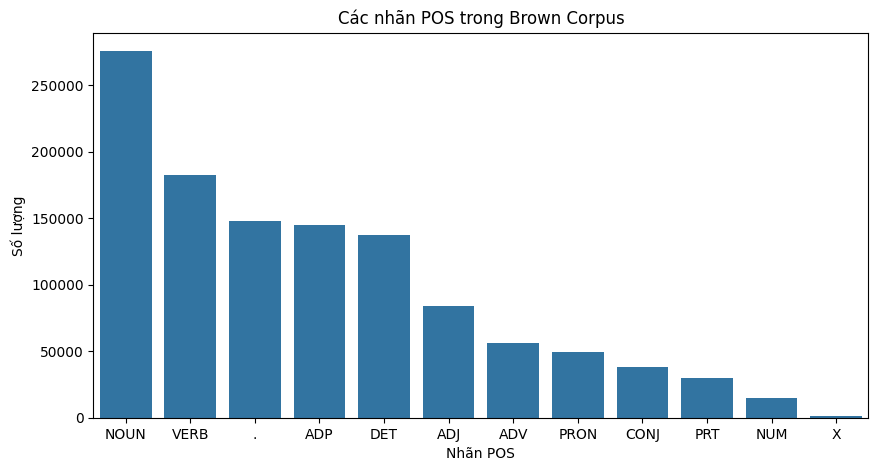

In [36]:
# ============================================================
# Phân bố nhãn POS
# ============================================================
from collections import Counter

tag_counts = Counter(all_tags)
tag_counts_df = pd.DataFrame.from_dict(tag_counts, orient='index', columns=['Count']).sort_values('Count', ascending=False)
tag_counts_df['Percentage'] = tag_counts_df['Count'] / tag_counts_df['Count'].sum() * 100

print("Phân bố nhãn POS:")
print(tag_counts_df)

# Vẽ biểu đồ phân bố nhãn POS
plt.figure(figsize=(10,5))
sns.barplot(x=tag_counts_df.index, y=tag_counts_df['Count'])
plt.title("Các nhãn POS trong Brown Corpus")
plt.ylabel("Số lượng")
plt.xlabel("Nhãn POS")
plt.show()


Chiều dài câu trung bình: 20.25
Chiều dài câu ngắn nhất: 1
Chiều dài câu dài nhất: 180


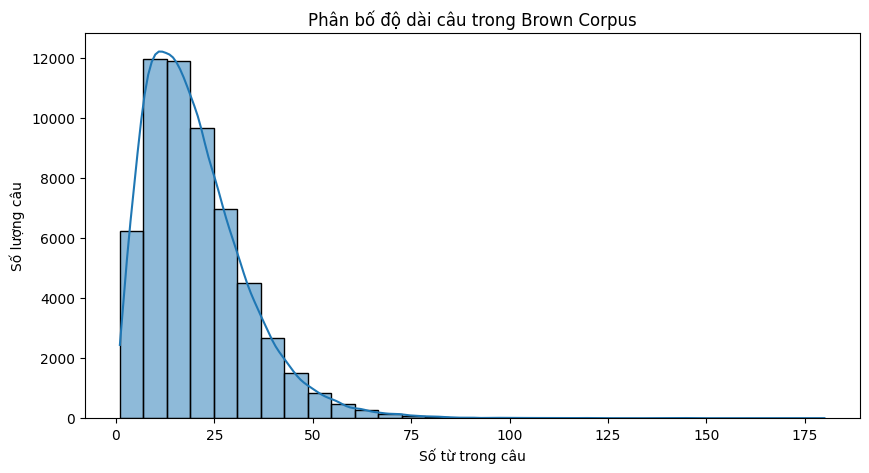

In [37]:
# ============================================================
# Chiều dài câu
# ============================================================
sentence_lengths = [len(sent) for sent in nltk_data_full]
print(f"Chiều dài câu trung bình: {np.mean(sentence_lengths):.2f}")
print(f"Chiều dài câu ngắn nhất: {np.min(sentence_lengths)}")
print(f"Chiều dài câu dài nhất: {np.max(sentence_lengths)}")

# Vẽ histogram độ dài câu
plt.figure(figsize=(10,5))
sns.histplot(sentence_lengths, bins=30, kde=True)
plt.title("Phân bố độ dài câu trong Brown Corpus")
plt.xlabel("Số từ trong câu")
plt.ylabel("Số lượng câu")
plt.show()


In [38]:
# ============================================================
# Từ phổ biến theo từng nhãn POS
# ============================================================
TOP_COMMON = 5
top_words_per_tag = {}
for tag in unique_tags:
    words_for_tag = [word.lower() for sent in nltk_data_full for word, t in sent if t == tag]
    counter = Counter(words_for_tag)
    top_words_per_tag[tag] = counter.most_common(TOP_COMMON)

print(f"Top {TOP_COMMON} từ phổ biến theo từng nhãn POS:")

top_words_df = pd.DataFrame({
    tag: [word for word, count in top_words_per_tag[tag]] for tag in unique_tags
})

top_words_df.index = [f"Top{i+1}" for i in range(TOP_COMMON)]

top_words_df


Top 5 từ phổ biến theo từng nhãn POS:


,ADV,CONJ,.,ADP,ADJ,DET,VERB,PRT,NOUN,NUM,X,PRON
Top1,not,and,",",of,other,the,is,to,time,one,de,he
Top2,when,but,.,in,new,a,was,all,man,two,la,it
Top3,so,or,``,to,first,his,be,there,af,three,et,i
Top4,only,nor,'',for,many,this,had,up,years,1,comedie,they
Top5,then,either,;,with,more,an,are,out,way,2,le,you


# **4. Tách tập train/test**

Trong bước này, chúng ta sẽ:

- Chia Brown corpus (`nltk_data_full`) thành tập **train** và **test** theo tỉ lệ cấu hình.
- Chuẩn hóa dữ liệu thành cặp `(sentence, tags)` để phù hợp với POS_HMM.
- In thông tin cơ bản về tập train/test và ví dụ mẫu.

In [39]:
# Cấu hình tỉ lệ test
CONFIG = {
    "TEST_SIZE": 0.2,  # 20% dữ liệu dùng cho tập test
}

# Chia dữ liệu raw thành train và test
train_raw, test_raw = train_test_split(
    nltk_data_full,
    test_size=CONFIG["TEST_SIZE"]
)

# Chuyển raw data thành X (words) và y (tags)
X_train = [[word for word, tag in sent] for sent in train_raw]
y_train = [[tag for word, tag in sent] for sent in train_raw]

X_test = [[word for word, tag in sent] for sent in test_raw]
y_test = [[tag for word, tag in sent] for sent in test_raw]

# ============================================================
# Thông tin cơ bản về tập train/test
# ============================================================

print(f"Số câu trong tập train: {len(X_train)}")
print(f"Số câu trong tập test: {len(X_test)}")

# In ví dụ một câu từ tập train và test
print("\nVí dụ câu train đầu tiên:")
print(X_train[0], "\nNhãn POS:", y_train[0])

print("\nVí dụ câu test đầu tiên:")
print(X_test[0], "\nNhãn POS:", y_test[0])


Số câu trong tập train: 45872
Số câu trong tập test: 11468

Ví dụ câu train đầu tiên:
['To', 'summarize', 'the', 'purpose', 'of', 'the', 'Skeletal', 'Maturity', 'Chart', ':', 'each', 'contains', 'two', 'kinds', 'of', 'skeletal', 'maturity', 'norms', 'which', 'show', 'two', 'quite', 'different', 'methods', 'of', 'depicting', 'developmental', 'level', 'of', 'growth', 'centers', '.'] 
Nhãn POS: ['PRT', 'VERB', 'DET', 'NOUN', 'ADP', 'DET', 'ADJ', 'NOUN', 'NOUN', '.', 'DET', 'VERB', 'NUM', 'NOUN', 'ADP', 'ADJ', 'NOUN', 'NOUN', 'DET', 'VERB', 'NUM', 'ADV', 'ADJ', 'NOUN', 'ADP', 'VERB', 'ADJ', 'NOUN', 'ADP', 'NOUN', 'NOUN', '.']

Ví dụ câu test đầu tiên:
['Discussion', '.'] 
Nhãn POS: ['NOUN', '.']


# **5. Train & Evaluate HMM cho POS tagging**

Trong bước này, chúng ta sẽ:

- Huấn luyện **POS_HMM** trên tập train với các giá trị `gamma` khác nhau.
- Dự đoán nhãn POS cho tập test và đánh giá độ chính xác, precision, recall, F1.
- Lưu kết quả vào bảng để dễ phân tích.

**Cấu hình tham số:**

- `GAMMA_LIST`: danh sách các giá trị gamma thử nghiệm trong POS_HMM.
- `AVERAGE_MODE`: cách tính trung bình cho precision/recall/F1 (`weighted`, `macro`, `micro`).

In [40]:
if GAMMA_TUNING:
  # ============================================================
  # Cấu hình tham số huấn luyện
  # ============================================================
  CONFIG = {
      "GAMMA_LIST": [1, 2, 3, 5, 7],       # danh sách giá trị gamma thử nghiệm
      "AVERAGE_MODE": "weighted"     # cách tính trung bình precision/recall/F1
  }

  # ============================================================
  # Danh sách lưu kết quả
  # ============================================================
  results = []

  # ============================================================
  # Huấn luyện và đánh giá với từng giá trị gamma
  # ============================================================
  for gamma in CONFIG["GAMMA_LIST"]:
      print(f"🔹 Training POS_HMM with gamma={gamma} ...")

      # Khởi tạo và huấn luyện mô hình
      pos_hmm = POS_HMM(gamma=gamma)
      pos_hmm.train(X_train, y_train)

      # Đánh giá trên tập test
      accuracy, precision, recall, f1 = pos_hmm.evaluate(X_test, y_test, average=CONFIG["AVERAGE_MODE"])

      # Lưu kết quả
      results.append({
          "gamma": gamma,
          "accuracy": accuracy,
          "precision": precision,
          "recall": recall,
          "f1": f1
      })

  # ============================================================
  # Hiển thị kết quả
  # ============================================================
  results_df = pd.DataFrame(results)
  print("Kết quả huấn luyện và đánh giá POS_HMM:")
  display(results_df)

🔹 Training POS_HMM with gamma=2 ...
[POS_HMM] Start training HMM for POS tagging...
[POS_HMM] Using device: cpu
[HMM] Starting supervised MLE training with (N, M)=(12, 27051)...
[HMM] Supervised MLE training completed.
[POS_HMM] Training complete successfully!
[POS_HMM] Evaluating on test data...
Kết quả huấn luyện và đánh giá POS_HMM:


,gamma,accuracy,precision,recall,f1
0,2,0.963783,tensor(0.9640),tensor(0.9638),tensor(0.9639)


gamma,Accuracy,Precision,Recall,F1
2,0.963783,tensor(0.9640),tensor(0.9638),tensor(0.9639)


Metric,Best gamma,Best Score
Accuracy,2,0.9638


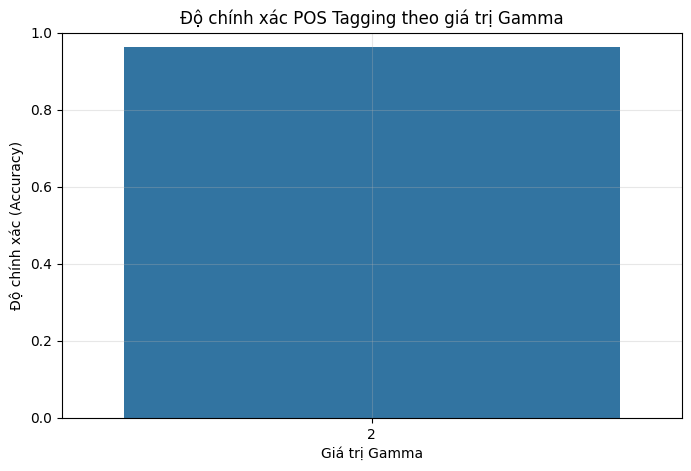

In [41]:
if GAMMA_TUNING:
  # ============================================================
  # Hiển thị bảng tổng hợp kết quả
  # ============================================================
  df_results = pd.DataFrame(results)

  # Đổi tên cột accuracy sang chữ hoa cho đồng nhất
  df_results.rename(columns={"accuracy": "Accuracy", "precision": "Precision", "recall": "Recall", "f1": "F1"}, inplace=True)

  display(df_results.style.hide(axis="index").format({
      "accuracy": "{:.4f}",
      "precision": "{:.4f}",
      "recall": "{:.4f}",
      "f1": "{:.4f}"
  }))

  # ============================================================
  # Chọn mô hình tốt nhất theo Accuracy
  # ============================================================
  idx_best = df_results["Accuracy"].idxmax()
  best_row = df_results.loc[idx_best]

  best_df = pd.DataFrame([{
      "Metric": "Accuracy",
      "Best gamma": best_row['gamma'],
      "Best Score": best_row['Accuracy']
  }])

  display(
      best_df.style.hide(axis="index").format({
          "Best gamma": "{:.0f}",
          "Best Score": "{:.4f}"
      })
  )

  # ============================================================
  # Vẽ biểu đồ so sánh Accuracy theo Gamma
  # ============================================================
  plt.figure(figsize=(8,5))
  sns.barplot(data=df_results, x="gamma", y="Accuracy")
  plt.title("Độ chính xác POS Tagging theo giá trị Gamma")
  plt.xlabel("Giá trị Gamma")
  plt.ylabel("Độ chính xác (Accuracy)")
  plt.ylim(0, 1.0)
  plt.grid(alpha=0.3)
  plt.show()


# 6. Train lại mô hình tốt nhất và lưu mô hình

Trong bước này, chúng ta sẽ:

- Huấn luyện lại **POS_HMM** với giá trị gamma tốt nhất dựa trên bảng kết quả trước.
- Lưu mô hình đã huấn luyện ra file để có thể sử dụng cho inference dữ liệu mới.
- Cho ví dụ load mô hình và dự đoán nhãn POS cho một câu mới.

In [42]:
# Thư mục muốn lưu
save_dir = "/content/ml-asm-dna05/features/BTL_MR"
os.makedirs(save_dir, exist_ok=True)  # tạo thư mục nếu chưa có

# Tên file đầy đủ
model_filename = os.path.join(save_dir, "best_pos_hmm.pkl")

In [43]:
if GAMMA_TUNING:
  # ============================================================
  # Huấn luyện lại mô hình tốt nhất
  # ============================================================
  best_gamma = best_row['gamma']
  print(f"🔹 Huấn luyện lại mô hình POS_HMM với gamma={best_gamma} ...")

  # Tạo và huấn luyện mô hình với gamma tốt nhất
  best_pos_hmm = POS_HMM(gamma=int(best_gamma))
  best_pos_hmm.train(X_train, y_train)

  print("[INFO] Huấn luyện xong mô hình tốt nhất!")

  with open(model_filename, "wb") as f:
      pickle.dump(best_pos_hmm, f)

  print(f"[INFO] Mô hình đã được lưu vào file: {model_filename}")

🔹 Huấn luyện lại mô hình POS_HMM với gamma=2 ...
[POS_HMM] Start training HMM for POS tagging...
[POS_HMM] Using device: cpu
[HMM] Starting supervised MLE training with (N, M)=(12, 27051)...
[HMM] Supervised MLE training completed.
[POS_HMM] Training complete successfully!
[INFO] Huấn luyện xong mô hình tốt nhất!
[INFO] Mô hình đã được lưu vào file: /content/ml-asm-dna05/features/BTL_MR/best_pos_hmm.pkl


In [44]:
# ============================================================
# Ví dụ load mô hình và dùng để dự đoán dữ liệu mới
# ============================================================

# Load lại mô hình
with open(model_filename, "rb") as f:
    loaded_model = pickle.load(f)

# Dự đoán một câu mới
example_sentence = ["This", "is", "a", "test", "."]
predicted_tags = loaded_model.predict_sentence(example_sentence)
print("\nVí dụ dự đoán POS cho câu mới:")
for word, tag in zip(example_sentence, predicted_tags):
    print(f"{word:10} -> {tag}")


Ví dụ dự đoán POS cho câu mới:
This       -> DET
is         -> VERB
a          -> DET
test       -> NOUN
.          -> .


In [45]:
# ============================================================
# IMPORTS
# ============================================================

raw_sentences = [
    "The ocean covers 70 percent of Earth's surface.",
    "It contains about 1.35 billion cubic kilometers (324 million cubic miles) of water, which is about 97 percent of all the water on Earth."
]

# ============================================================
# Tokenize câu raw thành danh sách từ
# ============================================================
test_sentences = [word_tokenize(sent) for sent in raw_sentences]

# In kết quả tokenization
print("\n===== KẾT QUẢ TOKENIZATION =====\n")
for i, tokens in enumerate(test_sentences, start=1):
    print(f"Câu {i}: {tokens}")
print("\n" + "="*60 + "\n")

# ============================================================
# DỰ ĐOÁN POS (sử dụng mô hình HMM đã load sẵn)
# ============================================================
# loaded_model ở đây là mô hình POS_HMM đã train và load
pred_tags = loaded_model.predict(test_sentences)

# ============================================================
# HIỂN THỊ KẾT QUẢ DỰ ĐOÁN POS
# ============================================================
print("\n===== KẾT QUẢ DỰ ĐOÁN POS CHO CÂU THỰC TẾ =====\n")

for i, (sentence, tags) in enumerate(zip(test_sentences, pred_tags), start=1):
    df = pd.DataFrame({
        "Từ (Word)": sentence,
        "Nhãn dự đoán (POS Tag)": tags
    })
    print(f"Câu {i}: {' '.join(sentence)}\n")
    print(tabulate(df, headers="keys", tablefmt="psql", showindex=False))


===== KẾT QUẢ TOKENIZATION =====

Câu 1: ['The', 'ocean', 'covers', '70', 'percent', 'of', 'Earth', "'s", 'surface', '.']
Câu 2: ['It', 'contains', 'about', '1.35', 'billion', 'cubic', 'kilometers', '(', '324', 'million', 'cubic', 'miles', ')', 'of', 'water', ',', 'which', 'is', 'about', '97', 'percent', 'of', 'all', 'the', 'water', 'on', 'Earth', '.']


[POS_HMM] Predicting in batch mode...

===== KẾT QUẢ DỰ ĐOÁN POS CHO CÂU THỰC TẾ =====

Câu 1: The ocean covers 70 percent of Earth 's surface .

+-------------+--------------------------+
| Từ (Word)   | Nhãn dự đoán (POS Tag)   |
|-------------+--------------------------|
| The         | DET                      |
| ocean       | NOUN                     |
| covers      | VERB                     |
| 70          | NUM                      |
| percent     | NOUN                     |
| of          | ADP                      |
| Earth       | NOUN                     |
| 's          | NOUN                     |
| surface     | NOUN   